# Events Table Stratified

__Description__: 
A stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for stratified sampling; maximum return interval limit for the stratified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: TBD


---
## Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*
import mean_frequency_curve
%matplotlib inline

### Parameters: 
#### Local (site specific):

In [2]:
## Excess rainfall parameters:
CN  = 81  # Curve number, must be an integer
mu  = 0.2  # Intial abstraction ratio parameter
PMP = 39.9  # [inches]; Probable maximum precipitation for the selected duration 
Return_Intervals = np.array([2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000])  # Return intervals for calculating runoff values.
RI_upper_bound = 3700  # Upper Limit of recurrence interval evaluation, suggest not changing this value
lower_limit = 1 # Lower limit of NOAA Atlas 14 precipitation values
Aerial_Reduction = 0.9216  # Aerial reduction factor
duration = 24  # [hours]; Event duration;  must be a duration in the input Precip_Table file

## Mean curve parameters:
return_intervals_mc = np.array([1.01, 1.05, 1.11, 1.25, 20, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 1/2E-06, 1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07]) # Additional return intervals for the mean curve inputs
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999]) # Confidence limits

## Integration parameter:
n_partition = 30  # Define number of partitions of max potential retention distribution; this controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'Amite_WA2'  # Project area name
Pluvial_Model = 'P01'  # Pluvial model name
BCN = '080702020804'  # Domain/boundary condition name
precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NOAA Data
precip_mean_curve_input_table = f'Mean_Curve_Input_{Project_Area}.csv'
precip_mean_curve_table = f'MeanCurve_{Project_Area}.csv'
CN_Distribution = 'NEH630_Table_10_1.json'

root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
precip_mean_curve_input_table_dir = outputs_dir/precip_mean_curve_input_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'

## Options:
display_print = False
np.set_printoptions(suppress=True)

##### Convert all paths to objects:

In [3]:
outputs_dir = pl.Path(outputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_input_table_dir = pl.Path(precip_mean_curve_input_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)

### Data:
#### NOAA Atlas 14 precipitation values:

,Median,Lower (90%),Upper (90%)
Tr,,,
1,4.278450,3.550713,5.134769
2,5.000066,4.145173,6.005280


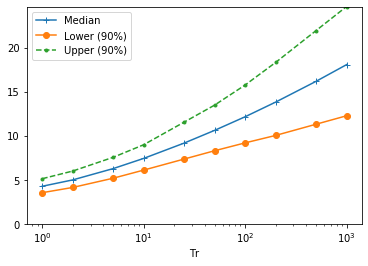

In [4]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)
raw_precip.rename(columns = {'Expected Value': 'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--'], logx=True, ylim=(0, raw_precip['Upper (90%)'].max()))
raw_precip.head(2)

#### Fit GEV to rainfall data (find GEV parameters):

In [5]:
## Reduce precipitation by aerial reduction factor:
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns]*Aerial_Reduction

## Find GEV parameter values:
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)
df_GEV_parameters = pd.concat([df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U], axis=1)
df_GEV_parameters

../../core\hydromet_stratified.py:60: RuntimeWarning:

divide by zero encountered in double_scalars



,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,4.411776,3.655813,5.289589
sigma,0.928430,0.856085,1.095949
xi,-0.178520,-0.076008,-0.232102


#### Plot fitted GEV distribution and NOAA data:

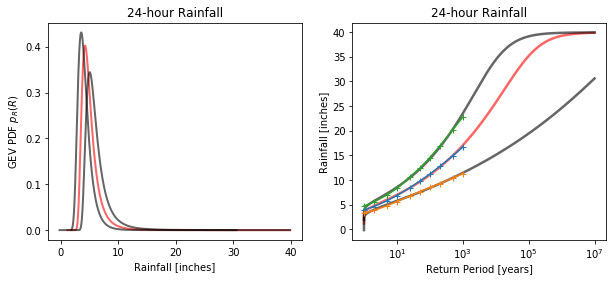

In [6]:
plot_GEV_precip_curves(raw_precip_reduced, df_GEV_parameters, PMP, 'Rainfall')

#### Data for calculating the mean curve:

In [7]:
return_interval_data = return_interval_data(raw_precip_reduced, return_intervals_mc, df_GEV_parameters, PMP)
return_interval_data.head(2)

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,3.943019,3.272337,4.732203,0.113339,0.110908,0.113339,1.371947
1.01,3.169220,2.419799,3.878684,0.164013,0.122803,0.164013,1.153486


#### Input for calculating the mean curve:

In [8]:
mean_curve_data = mean_curve_input_table(CL, return_interval_data, PMP, precip_mean_curve_input_table_dir)
mean_curve_data.head(2)

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,38.026092,38.452545,38.638075,39.073262,39.262603,39.453109,39.565093,39.644791,39.706751,39.757466,39.800410,39.837657,39.870549,39.885659,39.897189,39.898598,39.899720
2.000000e-07,37.094509,37.725234,38.001053,38.651407,38.935845,39.222943,39.392131,39.512733,39.606603,39.683510,39.748682,39.805247,39.855225,39.878194,39.895726,39.897868,39.899575


##### Calculate the mean precipitation curve:

Specified inputs_path is to a csv, loaded table.

Values increase with decreasing annual exceedance probability for all confidence limits as expected



,P_Mean_in,P_Median_in
AEP,,
0.9,3.530070,3.692513
0.5,4.719528,4.608061


C:\Users\mbartlettjr\Documents\GitHub\pfra-hydromet\Notebooks\pluvial\Outputs - already exists



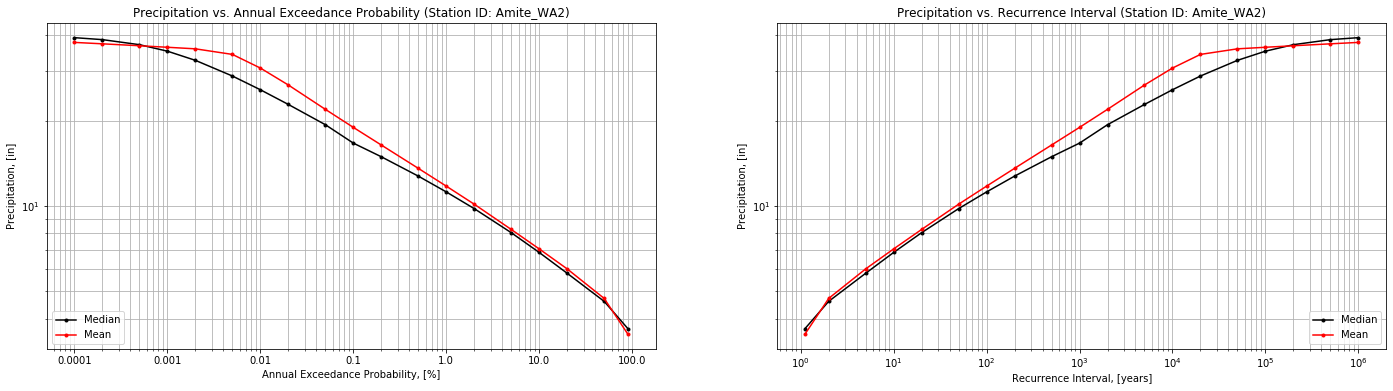

In [9]:
df = mean_frequency_curve.main(Project_Area, precip_mean_curve_input_table_dir, outputs_dir, data_type = 'P', round_decimals = 6)

---
## Hydrology 2
### Load Mean Curve:

,P_Mean_in,P_Median_in
Tr,,
1.111111,3.530070,3.692513
2.000000,4.719528,4.608061


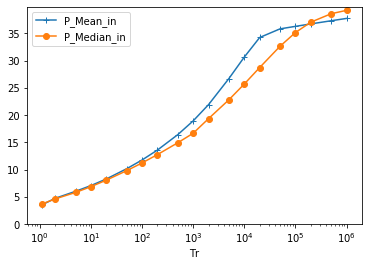

In [10]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir, index_col=0)
mean_curve_precip['Tr'] = 1.0/mean_curve_precip.index.values
mean_curve_precip.set_index('Tr', inplace = True)
mean_curve_precip.plot(style=['+-', 'o-'], logx=True, ylim=(0, PMP))
mean_curve_precip.head(2)

### Fit GEV to Mean Precipication Curve (Find GEV Parameters):

In [11]:
fit_values_mean_curve_precip = mean_curve_precip[1:20000] # Only fit the value up to about the 20,000 year event
df_GEV_parameters_E = GEV_parameters_Fit(fit_values_mean_curve_precip, 'P_Mean_in', PMP)
GEV_parameters_E = df_GEV_parameters_E.values.transpose()[0]
df_GEV_parameters = pd.concat([df_GEV_parameters, df_GEV_parameters_E], axis=1)
df_GEV_parameters 

,GEV Median,GEV Lower (90%),GEV Upper (90%),GEV P_Mean_in
mu,4.411776,3.655813,5.289589,4.267400
sigma,0.928430,0.856085,1.095949,0.918184
xi,-0.178520,-0.076008,-0.232102,-0.227794


#### Plot fitted GEV distribution and mean precipitation curve:

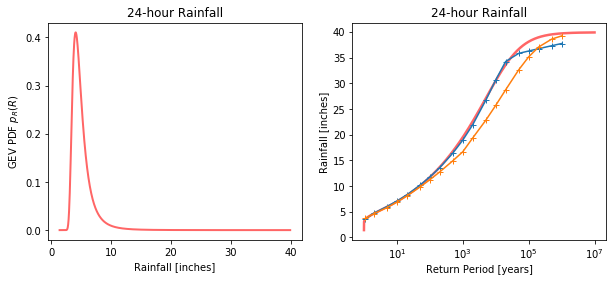

In [12]:
plot_GEV_precip_curves(mean_curve_precip, df_GEV_parameters_E, PMP, 'Rainfall')

### Hydrology 2 Events:

In [13]:
df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'P_Mean_in', CN, mu)
df_weights_rainfall #.head(2)

,Bin Floor,Bin Ceiling,Event Weight,P_Mean_in,Runoff
2.0,1.257114,4.099749,0.551555,4.719528,2.738878
5.0,4.099749,6.271597,0.084468,5.997485,3.881450
10.0,6.271597,19.206301,0.107383,7.053969,4.855268
25.0,19.206301,34.184150,0.022813,8.587114,6.298139
50.0,34.184150,81.768597,0.017024,10.141250,7.784274
100.0,81.768597,125.688325,0.004273,11.745087,9.334204
200.0,125.688325,380.936571,0.005331,13.570298,11.111686
500.0,380.936571,692.138872,0.001180,16.398151,13.884420
1000.0,692.138872,1607.598897,0.000823,18.923625,16.373337
2000.0,1607.598897,2575.487976,0.000234,21.910376,19.326874


---
## Hydrology 3:
### Retrieve Max Potential Retention Variability and Distribution Parameters:

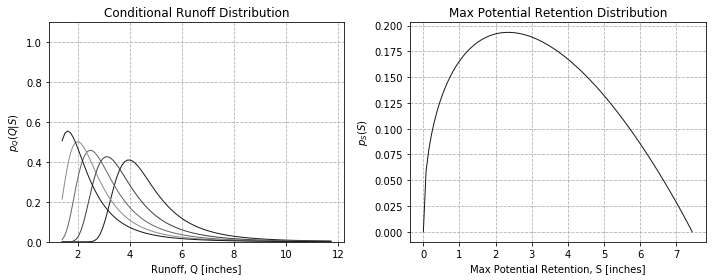

In [14]:
## NRCS value of wet and dry soil moiture conditions:
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

## Table of wet, dry, and average (or median) soil moisture conditions:
df_CN = prep_cn_table(CN, arc_data)  

## Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion:
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)
fitted_cn['mu'] = mu

## Distribution parameter values:
S_limit = 1000.0/fitted_cn.iloc[0]['CN Lower Limit']-10.0
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

## Define probability for each partition of the max potential retention distribution:
Delta_P = 1.0/n_partition

## Find the average value over each partition, which is the basis for the runoff distribution:
partition_avg = partition_S_avgs(n_partition, Delta_P, alpha, beta, S_limit)

plot_runoff_maxRetention_distributions(GEV_parameters_E, PMP, fitted_cn)

#### Calculate the error in the numerical CDF evaluated at PMP:

In [15]:
## Error between the integral approach (based on summation integration) and the actual value:
error_PQ = 1-CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P, 0)

print('\nProbability of zero runoff = {}\nError in calculation of Probabilibity of zero runoff = {}\n'
      'Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = {}'
      ''.format(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP, error_PQ)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP, error_PQ)[1], error_PQ))


Probability of zero runoff = 8.979370802954742e-80
Error in calculation of Probabilibity of zero runoff = 1.7561150321057457e-79
Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = -1.2926098949872511e-05


### Determine Runoff Values and Weights:
#### Fit GEV to runoff data (find GEV parameters):

In [16]:
df_runoff, df_GEV_parameters_R = runoff_GEV(mu, GEV_parameters_E, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
GEV_parameters_R = df_GEV_parameters_R.values.transpose()[0]
df_GEV_parameters_R

,GEV Runoff
mu,2.230981
sigma,0.850353
xi,-0.233377


#### Plot fitted rainfall and runoff GEV distributions:

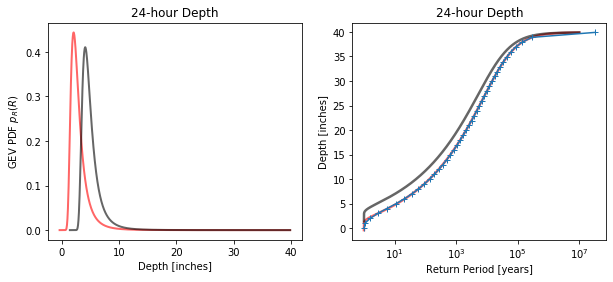

In [17]:
plot_GEV_precip_curves(df_runoff, pd.concat([df_GEV_parameters_R, df_GEV_parameters_E], axis=1), PMP, 'Depth')

#### Runoff weights:

In [18]:
df_weights_runoff = runoff_weights(Return_Intervals, RI_upper_bound, mu, GEV_parameters_R,  GEV_parameters_E, PMP, partition_avg, Delta_P, error_PQ)
df_weights_runoff.head(2)

,Bin Floor,Bin Ceiling,Event Weight,Runoff
2,1.256029,4.104649,0.552534,2.556324
5,4.104649,6.261186,0.083912,3.758035


#### Plot runoff distribution:

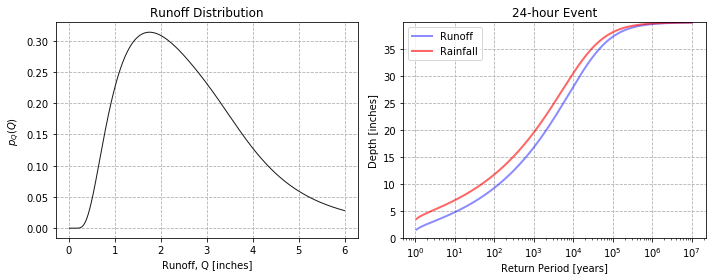

In [19]:
plot_runoff_distributions_final(GEV_parameters_E, GEV_parameters_R, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)

#### Plot maximum potential distribution conditional on runoff:

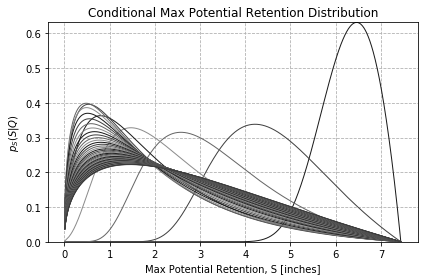

In [20]:
plot_max_potential_retention_cond_runoff(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)

### Calculate Runoff and Corresponding Max Potential Retention and Rainfall:

In [23]:
df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
df_runoff_SR1 #.head(2)

,Bin Floor,Bin Ceiling,Event Weight,Runoff,Avg. S,Rainfall (Avg. S),Median S,Rainfall (Median S)
2,1.256029,4.104649,0.552534,2.556324,2.775829,4.787920,2.535006,4.633670
5,4.104649,6.261186,0.083912,3.758035,1.945342,5.560709,1.605848,5.293008
10,6.261186,19.245872,0.107755,4.747518,1.824927,6.520095,1.445041,6.197607
25,19.245872,34.077934,0.022615,6.272427,1.891138,8.172537,1.500000,7.823066
50,34.077934,82.149883,0.017172,7.641864,1.987949,9.676650,1.610794,9.330479
100,82.149883,124.922359,0.004168,9.240526,2.092448,11.417009,1.731000,11.077288
200,124.922359,384.988269,0.005407,11.109598,2.195110,13.426356,1.849816,13.094595
500,384.988269,681.459082,0.001130,14.068163,2.321978,16.561824,1.998840,16.242840
1000,681.459082,1647.396284,0.000860,16.725669,2.409356,19.343996,2.102723,19.035523
2000,1647.396284,2492.068699,0.000206,19.767975,2.488375,22.501206,2.200931,22.206983


### Hydrology 3 Events:
- For each runoff value, two events are considered, a high max potential retention and a low max potential retention

In [24]:
df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
df_runoff_SR2 #.head(2)

,Event Weight,Runoff,Avg. S (Lower 50%),Rainfall (Lower 50%),Avg. S (Upper 50%),Rainfall (Upper 50%)
2,0.276267,2.556324,1.690066,4.056268,3.861592,5.442408
5,0.041956,3.758035,0.851645,4.643806,3.039038,6.353545
10,0.053877,4.747518,0.724943,5.531456,2.924912,7.376977
25,0.011307,6.272427,0.744461,7.093703,3.037815,9.118747
50,0.008586,7.641864,0.805644,8.537952,3.170254,10.686048
100,0.002084,9.240526,0.873464,10.218801,3.311432,12.489921
200,0.002704,11.109598,0.941532,12.170845,3.448688,14.561347
500,0.000565,14.068163,1.028569,15.236568,3.615387,17.774152
1000,0.000430,16.725669,1.090271,17.970911,3.728440,20.610595
2000,0.000103,19.767975,1.150556,21.088495,3.826193,23.814684


---
## End